## Setup

In [77]:
from sklearn.pipeline import Pipeline
from BMEMasterThesis.services.PicaiDataService import PicaiDataService
from BMEMasterThesis.visualizer import PicaiVisualizer
from BMEMasterThesis.utils import Datasets, PATHS
from BMEMasterThesis.algorithm import decodeMethod, decodeModel

from sklearn.discriminant_analysis import StandardScaler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import json

shap.initjs()

dataset = Datasets.N4

dataService = PicaiDataService()
radiomicsFile = PATHS.getRadiomicFile(dataset)
radiomicFeatures = pd.read_csv(radiomicsFile)
shapValuePlotDir = PATHS.getShapValuePlotDir(dataset)

picaiMetadata = dataService.getMetadata()    
        
jointDfs = pd.merge(picaiMetadata, radiomicFeatures, on='Patient_Id')
conditions = [
    (jointDfs['Label'] == 2) & (jointDfs['Manufacturer'] == 'Philips Medical Systems'),
    (jointDfs['Label'] == 2) & (jointDfs['Manufacturer'] == 'SIEMENS'),
    (jointDfs['Label'] > 2)  & (jointDfs['Manufacturer'] == 'Philips Medical Systems'),
    (jointDfs['Label'] > 2)  & (jointDfs['Manufacturer'] == 'SIEMENS'),
]

jointDfs['StratifiedLabels'] = np.select(conditions, [0, 1, 2, 3])
yStrat = jointDfs['StratifiedLabels'].to_numpy()

# Get features and original labels
patientIds = radiomicFeatures.pop('Patient_Id').to_list()
labels = radiomicFeatures.pop('Label')
radiomicFeaturesNames = radiomicFeatures.columns.to_list()

X = radiomicFeatures.to_numpy()
y = np.copy(labels)
y[y == 2] = 0   # 0: ISUP = 2,
y[y > 2] = 1    # 1: ISUP > 2

indicesData = json.load(PATHS.PICAI_INDICES_FILE.open())
train_index = np.asarray(indicesData['train_idx'])
test_index = np.asarray(indicesData['test_idx'])

Xtrain, Xtest = X[train_index], X[test_index]
ytrain, ytest = y[train_index], y[test_index]

print(Xtrain.shape, Xtest.shape)
print(ytrain.shape, ytest.shape)

bestMethod, bestModel = PicaiVisualizer(dataService=dataService).visualizeDataset(dataset)
bestMethodResultFile = PATHS.getResultsForCombinationDir(dataset, bestMethod, bestModel)
bestMethodParams = json.load(bestMethodResultFile.open())['best_method_params']

print(bestMethod, bestModel)

(146, 1132) (79, 1132)
(146,) (79,)
surfstar svm-linear


## Fit pipeline

In [61]:
method = decodeMethod(bestMethod)
method.set_params(**bestMethodParams)
model = decodeModel(bestModel)

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('feature_selector', method),
    ('classifier', model)
])

pipeline.fit(Xtrain, ytrain)
pipeline

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('feature_selector',
                 SURFstar(n_features_to_select=78, n_jobs=-1)),
                ('classifier', SVC(kernel='linear'))])

## Train PCA

In [66]:
from sklearn.decomposition import PCA

print(pipeline.named_steps['feature_selector'].get_params())

selectedFeatures = pipeline.named_steps['feature_selector'].top_features_[:pipeline.named_steps['feature_selector'].n_features_to_select]
# selectedFeatures = pipeline.named_steps['feature_selector'].selectedFeatures
print(len(selectedFeatures))


# XtestSelected = StandardScaler().fit_transform(Xtest[:, selectedFeatures])
# XtestSelected = StandardScaler().fit_transform(Xtrain[:, selectedFeatures])
Xstd = StandardScaler().fit_transform(Xtest[:, selectedFeatures])
# print(XtestSelected.shape)


pca = PCA(n_components=3)
principalComponents = pca.fit_transform(Xstd)
principalDf = pd.DataFrame(data=principalComponents, columns = ['PC 1', 'PC 2', 'PC 3'])
df = pd.DataFrame(Xstd)
df['target'] = ytest
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
finalDf

{'discrete_threshold': 10, 'n_features_to_select': 78, 'n_jobs': -1, 'verbose': False}
78


,PC 1,PC 2,PC 3,target
0,2.324293,-0.699386,2.380851,0
1,-4.959776,1.795369,-1.785719,0
2,-0.323047,-2.850634,0.789806,0
3,-1.600756,-1.218408,-1.027029,0
4,-2.241373,-2.590261,0.502349,1
...,...,...,...,...
74,0.159116,-1.306302,-2.027248,0
75,17.228875,3.337164,6.861544,1
76,-5.646782,-1.521504,1.956212,0
77,-1.084296,-1.850590,-0.604973,0


## Generate Plots

[50.05346546  9.85265648  4.42407037]
[0.63358817 0.12471717 0.05600089]


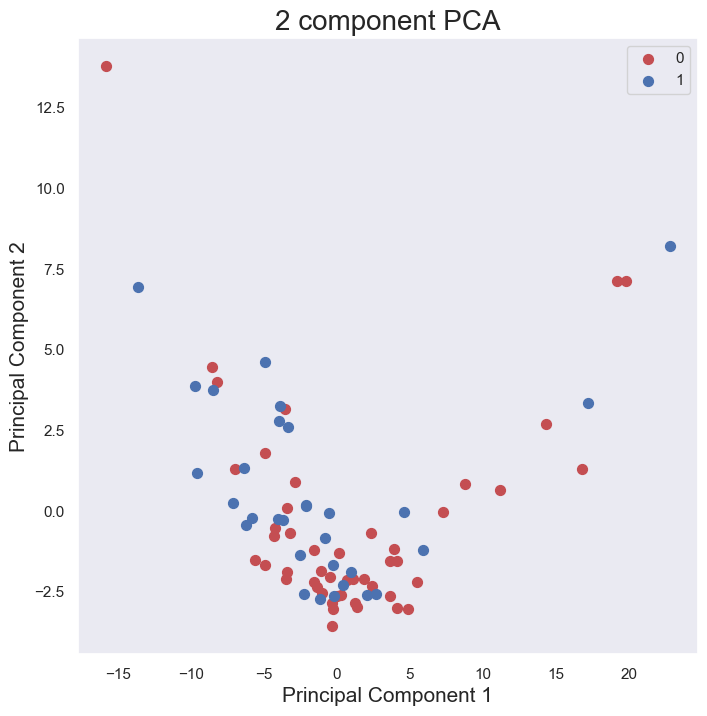

In [67]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
               , finalDf.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)


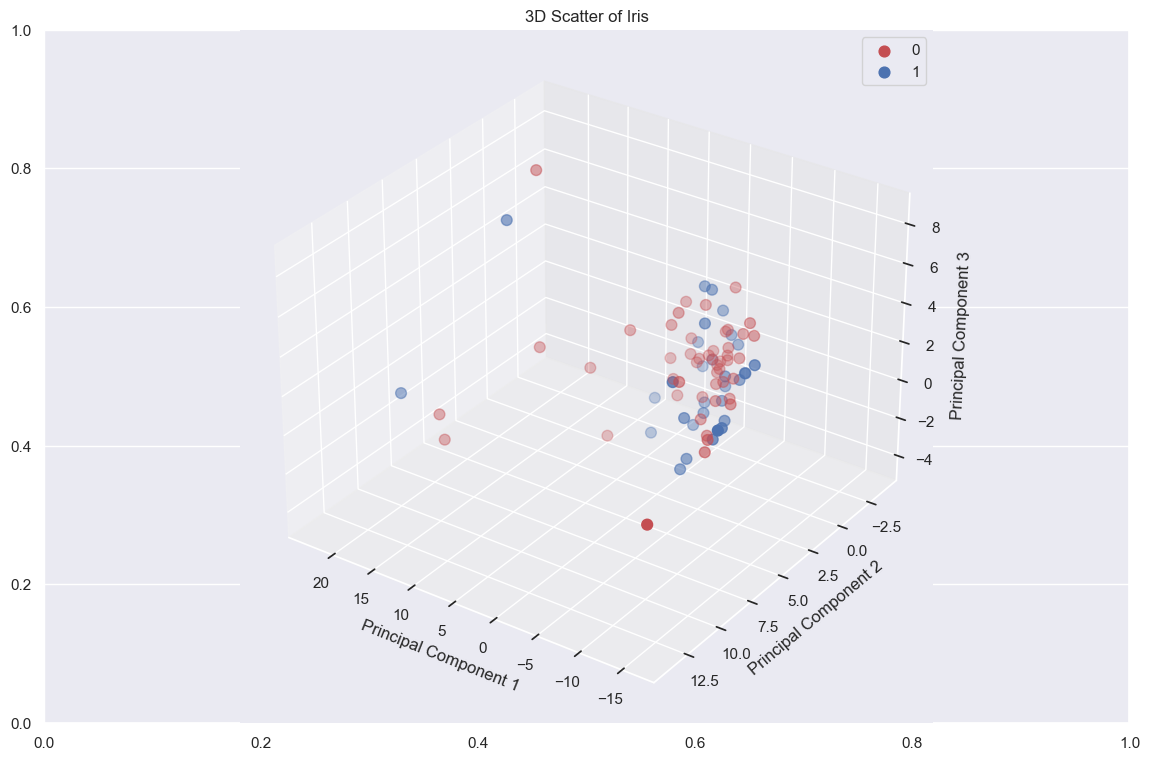

[50.05346546  9.85265648  4.42407037]
[0.63358817 0.12471717 0.05600089]


In [68]:
fig = plt.figure(figsize = (14,9))
ax = fig.add_subplot(1,1,1) 
ax = plt.axes(projection='3d')

# ax.scatter3D(finalDf['PC 1'], finalDf['PC 2'], finalDf['PC 3'], c=finalDf['PC 3'], cmap='viridis')
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1'], finalDf.loc[indicesToKeep, 'PC 2'], finalDf.loc[indicesToKeep, 'PC 3'], c = color, s = 60)
ax.legend(targets)
ax.grid()

# Plot title of graph
plt.title(f'3D Scatter of Iris')

# Plot x, y, z even ticks
# ticks = np.linspace(-3, 3, num=5)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_zticks(ticks)

# Plot x, y, z labels
ax.set_xlabel('Principal Component 1', rotation=150)
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3', rotation=60)
ax.view_init(30, 125)
plt.show()

ax.set_title('3 component PCA', fontsize = 20)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)


## t-SNE

In [87]:
from sklearn.manifold import TSNE
import seaborn as sns


selectedFeatures = pipeline.named_steps['feature_selector'].top_features_[:pipeline.named_steps['feature_selector'].n_features_to_select]
# selectedFeatures = pipeline.named_steps['feature_selector'].selectedFeatures
print(len(selectedFeatures))


# XtestSelected = StandardScaler().fit_transform(Xtest[:, selectedFeatures])
# XtestSelected = StandardScaler().fit_transform(Xtrain[:, selectedFeatures])
Xstd = StandardScaler().fit_transform(Xtest[:, selectedFeatures])
# print(XtestSelected.shape)


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(Xstd)
print(tsne_results.shape)

tsneDf = pd.DataFrame(data=tsne_results, columns = ['tsne 1', 'tsne 2'])
print(tsneDf)
tsneDf['y'] = ytest


78
[t-SNE] Computing 78 nearest neighbors...
[t-SNE] Indexed 79 samples in 0.000s...
[t-SNE] Computed neighbors for 79 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 79 / 79
[t-SNE] Mean sigma: 4.662924
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.838211
[t-SNE] KL divergence after 700 iterations: 0.078117
(79, 2)
      tsne 1    tsne 2
0  -3.522916 -1.099594
1   0.846504  0.854096
2  -1.842209 -0.291537
3  -1.074695  0.675159
4  -0.976295 -0.336801
..       ...       ...
74 -1.895737  0.960176
75 -5.714746  0.261858
76  0.514149 -0.617570
77 -1.386314  0.319562
78  0.030166  0.712464

[79 rows x 2 columns]


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='tsne 1', ylabel='tsne 2'>

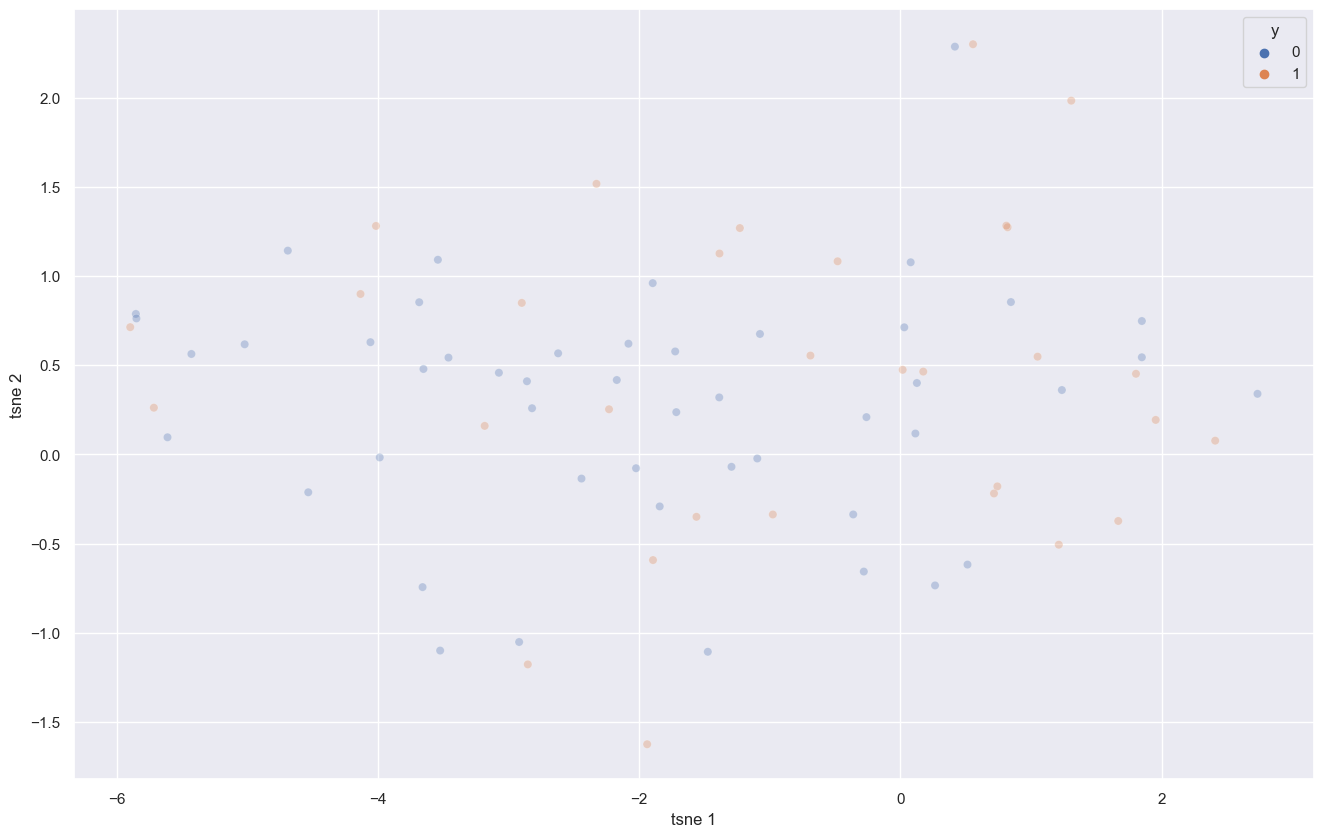

In [88]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne 1", y="tsne 2",
    hue="y",
    # palette=sns.color_palette("hls", 10),
    data=tsneDf,
    legend="full",
    alpha=0.3
)